## Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib widget

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as data_utils

import skorch
from skorch import NeuralNetRegressor

from sklearn.preprocessing import MinMaxScaler



## Loading in dataframe

In [2]:
data_path = '../processed_data.csv'
data = pd.read_csv(data_path, index_col=0)
data['energy(kWh/hh)'] = data['energy(kWh/hh)'].astype(float) / data['houses']
display(data.head())

scaler = MinMaxScaler()

data['energy(kWh/hh)'] = scaler.fit_transform(data[['energy(kWh/hh)']])
display(data.info())
display(data.head())


,timestamp,year,month,day,hour,minute,day_of_week,weekend,holiday,energy(kWh/hh),houses,visibility,temperature,dewPoint,pressure,windSpeed,precipType,humidity
index,,,,,,,,,,,,,,,,,,
0,2011-11-23 09:00:00+00:00,2011,11,23,9,0,2,0,0,0.284500,2,4.390000,4.840000,4.680000,1027.290000,1.780000,0,0.990000
1,2011-11-23 09:30:00+00:00,2011,11,23,9,30,2,0,0,0.280500,2,5.068612,5.190130,5.095420,1027.507662,1.824055,0,0.992222
2,2011-11-23 10:00:00+00:00,2011,11,23,10,0,2,0,0,0.153333,6,6.240000,5.740000,5.460000,1027.670000,1.990000,0,0.980000
3,2011-11-23 10:30:00+00:00,2011,11,23,10,30,2,0,0,0.098000,6,8.261031,6.686929,5.598355,1027.672961,2.336091,0,0.931400
4,2011-11-23 11:00:00+00:00,2011,11,23,11,0,2,0,0,0.110286,7,10.200000,7.670000,5.740000,1027.560000,2.660000,0,0.880000


<class 'pandas.core.frame.DataFrame'>
Index: 39727 entries, 0 to 39726
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   timestamp       39727 non-null  object 
 1   year            39727 non-null  int64  
 2   month           39727 non-null  int64  
 3   day             39727 non-null  int64  
 4   hour            39727 non-null  int64  
 5   minute          39727 non-null  int64  
 6   day_of_week     39727 non-null  int64  
 7   weekend         39727 non-null  int64  
 8   holiday         39727 non-null  int64  
 9   energy(kWh/hh)  39727 non-null  float64
 10  houses          39727 non-null  int64  
 11  visibility      39727 non-null  float64
 12  temperature     39727 non-null  float64
 13  dewPoint        39727 non-null  float64
 14  pressure        39727 non-null  float64
 15  windSpeed       39727 non-null  float64
 16  precipType      39727 non-null  int64  
 17  humidity        39727 non-null  floa

None

,timestamp,year,month,day,hour,minute,day_of_week,weekend,holiday,energy(kWh/hh),houses,visibility,temperature,dewPoint,pressure,windSpeed,precipType,humidity
index,,,,,,,,,,,,,,,,,,
0,2011-11-23 09:00:00+00:00,2011,11,23,9,0,2,0,0,0.496932,2,4.390000,4.840000,4.680000,1027.290000,1.780000,0,0.990000
1,2011-11-23 09:30:00+00:00,2011,11,23,9,30,2,0,0,0.486617,2,5.068612,5.190130,5.095420,1027.507662,1.824055,0,0.992222
2,2011-11-23 10:00:00+00:00,2011,11,23,10,0,2,0,0,0.158681,6,6.240000,5.740000,5.460000,1027.670000,1.990000,0,0.980000
3,2011-11-23 10:30:00+00:00,2011,11,23,10,30,2,0,0,0.015988,6,8.261031,6.686929,5.598355,1027.672961,2.336091,0,0.931400
4,2011-11-23 11:00:00+00:00,2011,11,23,11,0,2,0,0,0.047670,7,10.200000,7.670000,5.740000,1027.560000,2.660000,0,0.880000


## Adding Input and target columns

In [3]:

data_mod = data.drop(['timestamp', 'holiday', 'houses', 'visibility', 'pressure', 'windSpeed'], axis=1)
timesteps = 48

columns_before = len(data_mod.columns.to_list())

for i in range(1, timesteps+1):
    if i < timesteps:
        data_mod['energy(kWh/hh)_prev_' + str(i*.5)] = data_mod['energy(kWh/hh)'].shift(i)
    data_mod['energy(kWh/hh)_next_' + str(i*.5)] = data_mod['energy(kWh/hh)'].shift(-i)



columns = data_mod.columns.to_list()
columns.remove('energy(kWh/hh)')
prev_column = [col for col in columns if 'prev' in col]
prev_column.reverse()
next_column = [col for col in columns if 'next' in col]
columns = columns[:columns_before-1] + prev_column + ['energy(kWh/hh)'] + next_column
print(columns)

data_mod = data_mod[columns]

print(len(prev_column+['energy(kWh/hh)']))
print(len(next_column))

['year', 'month', 'day', 'hour', 'minute', 'day_of_week', 'weekend', 'temperature', 'dewPoint', 'precipType', 'humidity', 'energy(kWh/hh)_prev_23.5', 'energy(kWh/hh)_prev_23.0', 'energy(kWh/hh)_prev_22.5', 'energy(kWh/hh)_prev_22.0', 'energy(kWh/hh)_prev_21.5', 'energy(kWh/hh)_prev_21.0', 'energy(kWh/hh)_prev_20.5', 'energy(kWh/hh)_prev_20.0', 'energy(kWh/hh)_prev_19.5', 'energy(kWh/hh)_prev_19.0', 'energy(kWh/hh)_prev_18.5', 'energy(kWh/hh)_prev_18.0', 'energy(kWh/hh)_prev_17.5', 'energy(kWh/hh)_prev_17.0', 'energy(kWh/hh)_prev_16.5', 'energy(kWh/hh)_prev_16.0', 'energy(kWh/hh)_prev_15.5', 'energy(kWh/hh)_prev_15.0', 'energy(kWh/hh)_prev_14.5', 'energy(kWh/hh)_prev_14.0', 'energy(kWh/hh)_prev_13.5', 'energy(kWh/hh)_prev_13.0', 'energy(kWh/hh)_prev_12.5', 'energy(kWh/hh)_prev_12.0', 'energy(kWh/hh)_prev_11.5', 'energy(kWh/hh)_prev_11.0', 'energy(kWh/hh)_prev_10.5', 'energy(kWh/hh)_prev_10.0', 'energy(kWh/hh)_prev_9.5', 'energy(kWh/hh)_prev_9.0', 'energy(kWh/hh)_prev_8.5', 'energy(kWh/h

## Removing Datapoints without previous or next info

In [4]:
# Removing NaN value rows
data_mod_clean = data_mod[data_mod[prev_column[0]].notna()]
data_mod_clean = data_mod_clean[data_mod_clean[next_column[-1]].notna()]
data_mod_clean = data_mod_clean.reset_index(drop=True)

data_mod_clean.to_csv('../processed_data_train.csv', index=False)

display(data_mod_clean.head())
display(data_mod_clean.tail())

,year,month,day,hour,minute,day_of_week,weekend,temperature,dewPoint,precipType,...,energy(kWh/hh)_next_19.5,energy(kWh/hh)_next_20.0,energy(kWh/hh)_next_20.5,energy(kWh/hh)_next_21.0,energy(kWh/hh)_next_21.5,energy(kWh/hh)_next_22.0,energy(kWh/hh)_next_22.5,energy(kWh/hh)_next_23.0,energy(kWh/hh)_next_23.5,energy(kWh/hh)_next_24.0
0,2011,11,24,8,30,3,0,9.737390,9.029200,0,...,0.221053,0.171747,0.125122,0.107071,0.152767,0.144618,0.147816,0.234669,0.254990,0.224973
1,2011,11,24,9,0,3,0,10.120000,9.410000,0,...,0.171747,0.125122,0.107071,0.152767,0.144618,0.147816,0.234669,0.254990,0.224973,0.260080
2,2011,11,24,9,30,3,0,10.508810,9.687960,0,...,0.125122,0.107071,0.152767,0.144618,0.147816,0.234669,0.254990,0.224973,0.260080,0.204140
3,2011,11,24,10,0,3,0,10.990000,9.930000,0,...,0.107071,0.152767,0.144618,0.147816,0.234669,0.254990,0.224973,0.260080,0.204140,0.239292
4,2011,11,24,10,30,3,0,11.649751,10.203041,0,...,0.152767,0.144618,0.147816,0.234669,0.254990,0.224973,0.260080,0.204140,0.239292,0.165834


,year,month,day,hour,minute,day_of_week,weekend,temperature,dewPoint,precipType,...,energy(kWh/hh)_next_19.5,energy(kWh/hh)_next_20.0,energy(kWh/hh)_next_20.5,energy(kWh/hh)_next_21.0,energy(kWh/hh)_next_21.5,energy(kWh/hh)_next_22.0,energy(kWh/hh)_next_22.5,energy(kWh/hh)_next_23.0,energy(kWh/hh)_next_23.5,energy(kWh/hh)_next_24.0
39627,2014,2,26,22,0,2,0,6.240000,3.110000,0,...,0.452177,0.551650,0.667100,0.695996,0.687456,0.658115,0.652315,0.626403,0.587816,0.536284
39628,2014,2,26,22,30,2,0,6.259442,3.160875,0,...,0.551650,0.667100,0.695996,0.687456,0.658115,0.652315,0.626403,0.587816,0.536284,0.498642
39629,2014,2,26,23,0,2,0,6.270000,3.170000,0,...,0.667100,0.695996,0.687456,0.658115,0.652315,0.626403,0.587816,0.536284,0.498642,0.413828
39630,2014,2,26,23,30,2,0,6.114206,3.198318,0,...,0.695996,0.687456,0.658115,0.652315,0.626403,0.587816,0.536284,0.498642,0.413828,0.318439
39631,2014,2,27,0,0,3,0,6.010000,3.240000,0,...,0.687456,0.658115,0.652315,0.626403,0.587816,0.536284,0.498642,0.413828,0.318439,0.302225


## Simple Feed Forward Network

In [5]:
class ForecastNetwork(nn.Module):
    def __init__(self, input_time_dim, input_other_dim, output_dim, layers, nodes, activation=nn.ReLU):
        super(ForecastNetwork, self).__init__()
        self.input_time_dim = input_time_dim
        self.input_dim = input_other_dim
        self.output_dim = output_dim
        self.layers = layers
        self.nodes = nodes
        self.conv_channels = 4
        self.kernel_size = 8

        self.conv_dim = int((input_time_dim - 1*(self.kernel_size-1) -1)/1 + 1)

        layers = []

        # Time convolution
        self.unflat = nn.Unflatten(1, (1, self.input_time_dim))
        self.conv1 = nn.Conv1d(1, self.conv_channels, self.kernel_size, bias=False)
        self.flat = nn.Flatten()

        for i in range(self.layers):
            if i == 0:
                layers.append(nn.Linear(self.input_dim + self.conv_dim*self.conv_channels, self.nodes))
                layers.append(activation())
            elif i == self.layers - 1:
                layers.append(nn.Linear(self.nodes, self.output_dim))
            else:
                layers.append(nn.Linear(self.nodes, self.nodes))
                layers.append(activation())

        self.module = nn.Sequential(*layers)

    
    def forward(self, x):
        conv = self.unflat(x[:, self.input_dim:])
        conv = self.conv1(conv)
        conv = self.flat(conv)
        conv = torch.cat((conv, x[:, :self.input_dim]), dim=1)
        out = self.module(conv)
        return out


## Making datasets

In [6]:
other_features = [
    'month', 
    'day', 
    'hour', 
    'minute', 
    'day_of_week', 
    'weekend', 
    'temperature', 
    'precipType', 
    'humidity', 
]
input_names = other_features + prev_column + ['energy(kWh/hh)']

target_names = next_column

data_mod_clean = pd.read_csv('../processed_data_train.csv')

inputs = data_mod_clean[input_names]
targets = data_mod_clean[target_names]

input_tensor = torch.tensor(inputs.values).float()
target_tensor = torch.tensor(targets.values).float()

dataset_train = data_utils.TensorDataset(input_tensor[:int(len(input_tensor) * 0.8)], target_tensor[:int(len(target_tensor) * 0.8)])
dataset_test = data_utils.TensorDataset(input_tensor[int(len(input_tensor) * 0.8):], target_tensor[int(len(target_tensor) * 0.8):])


## Skorch Training

In [7]:
module = ForecastNetwork(timesteps, len(other_features), target_tensor.shape[1], 6, 250)

In [8]:
net = NeuralNetRegressor(
    module,
    max_epochs=100,
    lr=0.0001,
    batch_size=64,
    optimizer=torch.optim.Adam,
    optimizer__weight_decay=0.00001,
    criterion=nn.MSELoss,
    device='cuda',
    iterator_train__num_workers=4,
    iterator_train__pin_memory=True,
    iterator_train__shuffle=False,
    iterator_valid__num_workers=4,
    iterator_valid__pin_memory=True
)

net = net.fit(dataset_train, y=None)

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.0259        0.0595  0.8724
      2        0.0076        0.0499  0.7019
      3        0.0048        0.0475  0.7078
      4        0.0041        0.0467  0.6958
      5        0.0037        0.0455  0.7062
      6        0.0035        0.0455  0.7029
      7        0.0033        0.0452  0.6870
      8        0.0032        0.0440  0.7094
      9        0.0031        0.0451  0.7215
     10        0.0031        0.0444  0.7122
     11        0.0031        0.0440  0.7499
     12        0.0030        0.0433  0.7163
     13        0.0028        0.0417  0.7269
     14        0.0027        0.0403  0.7169
     15        0.0026        0.0415  0.7156
     16        0.0025        0.0421  0.7129
     17        0.0025        0.0419  0.7093
     18        0.0024        0.0422  0.7057
     19        0.0024        0.0421  0.7290
     20        0.0023        0.0418  0.7123
     21        0.0022        0.0

## Testing Training

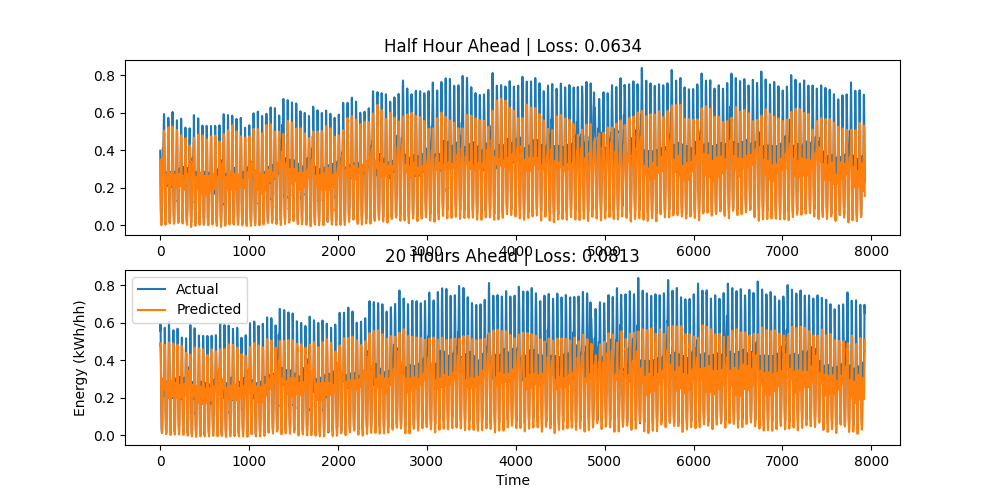

In [9]:
loss = nn.L1Loss()
x_test = dataset_test[:][0]
y_test = dataset_test[:][1]

y_pred = net.module(x_test.float().cuda()).cpu().detach()

half_pred = y_pred[:, 0]

half_loss = loss(y_pred[:, 0], y_test[:, 0]).item()
hour_loss = loss(y_pred[:, 1], y_test[:, 1]).item()
hour_half_loss = loss(y_pred[:, 2], y_test[:, 2]).item()
hour_20_loss = loss(y_pred[:, 40], y_test[:, 40])

fig, ax = plt.subplots(2, 1, figsize=(10, 5))
ax[0].plot(y_test[:, 0], label='Actual')
ax[0].plot(y_pred[:, 0], label='Predicted')
ax[0].set_title(f'Half Hour Ahead | Loss: {half_loss:.4f}')

#ax[1].plot(y_test[:, 1], label='Actual')
#ax[1].plot(y_pred[:, 1], label='Predicted')
#ax[1].set_title(f'Hour Ahead | Loss: {hour_loss:.4f}')

#ax[2].plot(y_test[:, 2], label='Actual')
#ax[2].plot(y_pred[:, 2], label='Predicted')
#ax[2].set_title(f'Hour and Half Ahead | Loss: {hour_half_loss:.4f}')

ax[1].plot(y_test[:, 40], label='Actual')
ax[1].plot(y_pred[:, 40], label='Predicted')
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Energy (kWh/hh)')
ax[1].set_title(f'20 Hours Ahead | Loss: {hour_20_loss:.4f}')

plt.legend()
plt.show()

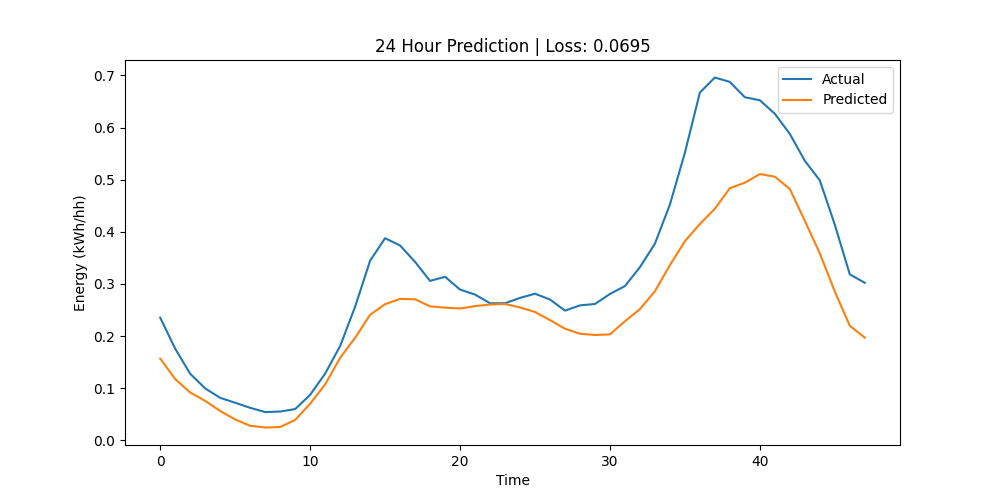

In [10]:
loss = nn.L1Loss()

x_test, y_test = dataset_test[:]

y_pred = net.module(x_test.float().cuda()).cpu().detach().squeeze()

overall_loss = loss(y_pred, y_test).item()

fig, ax = plt.subplots(1, 1, figsize=(10, 5))

ax.plot(y_test[-1], label='Actual')
ax.plot(y_pred[-1], label='Predicted')
ax.set_xlabel('Time')
ax.set_ylabel('Energy (kWh/hh)')
ax.set_title(f'24 Hour Prediction | Loss: {overall_loss:.4f}')
plt.legend()


In [33]:
class ForecastLSTM(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length, other_feature_size, device='cuda', bidirectional=False, dropout=0.1):
        super(ForecastLSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.other_feature_size = other_feature_size
        self.device = device
        self.num_directions = 2 if bidirectional else 1

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True, dropout=dropout, bidirectional=bidirectional)
        
        self.fc1 = nn.Linear(hidden_size*self.num_directions*self.input_size, hidden_size)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, 1)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(seq_length + other_feature_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers*self.num_directions, x.size(0), self.hidden_size)).to(self.device)
        
        c_0 = Variable(torch.zeros(
            self.num_layers*self.num_directions, x.size(0), self.hidden_size)).to(self.device)

        x_other = x[:, :self.other_feature_size, :].squeeze(-1)
        x_lstm = x[:, self.other_feature_size:, :]
        
        h_all, (h_out, c_out) = self.lstm(x_lstm, (h_0, c_0))

        out = self.fc1(h_all).squeeze(-1)  
        out = self.relu1(out)
        out = self.fc2(out).squeeze(-1)
        out = self.relu2(out)
        
        out = torch.cat((out, x_other), dim=1)
        out = self.fc3(out)
        
        return out

In [9]:
data_mod_clean = pd.read_csv('../processed_data_train.csv')

inputs = data_mod_clean[input_names]
targets = data_mod_clean[target_names]

input_tensor = torch.tensor(inputs.values).float().unsqueeze(-1)
target_tensor = torch.tensor(targets.values).float()

dataset_train = data_utils.TensorDataset(input_tensor[:int(len(input_tensor) * 0.8)], target_tensor[:int(len(target_tensor) * 0.8)])
dataset_test = data_utils.TensorDataset(input_tensor[int(len(input_tensor) * 0.8):], target_tensor[int(len(target_tensor) * 0.8):])


In [47]:
module = ForecastLSTM(target_tensor.shape[1], 1, 48, 3, timesteps, len(other_features), bidirectional=True, dropout=0.0).to('cuda')

test = module(input_tensor[0].unsqueeze(0).cuda())

In [48]:
net = NeuralNetRegressor(
    module,
    max_epochs=400,
    lr=0.0001,
    batch_size=128,
    optimizer=torch.optim.Adam,
    optimizer__weight_decay=0.00001,
    criterion=nn.MSELoss,
    device='cuda',
    iterator_train__num_workers=4,
    iterator_train__pin_memory=True,
    iterator_train__shuffle=False,
    iterator_valid__num_workers=4,
    iterator_valid__pin_memory=True
)

net = net.fit(dataset_train, y=None)

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        4.4117        2.3095  0.9462
      2        1.8598        1.7767  0.9154
      3        1.4420        1.4313  0.9208
      4        1.1426        1.1518  0.9086
      5        0.9054        0.9298  0.9153
      6        0.7192        0.7548  0.9272
      7        0.5740        0.6171  0.8991
      8        0.4610        0.5085  0.8988
      9        0.3727        0.4225  0.9081
     10        0.3035        0.3540  0.9308
     11        0.2489        0.2990  0.9277
     12        0.2054        0.2545  0.9204
     13        0.1707        0.2183  0.9302
     14        0.1428        0.1888  0.9197
     15        0.1203        0.1646  0.9098
     16        0.1020        0.1447  0.9273
     17        0.0873        0.1283  0.9242
     18        0.0754        0.1149  0.9157
     19        0.0658        0.1039  0.9305
     20        0.0580        0.0950  0.9205
     21        0.0517        0.0

In [44]:
import os
cody_model_dir = '../models/cody_models'
net.save_params(f_params=os.path.join(cody_model_dir, 'lstm_params.pkl'),
                f_optimizer=os.path.join(cody_model_dir, 'lstm_optimizer.pkl'),
                f_history=os.path.join(cody_model_dir, 'lstm_history.json')
)

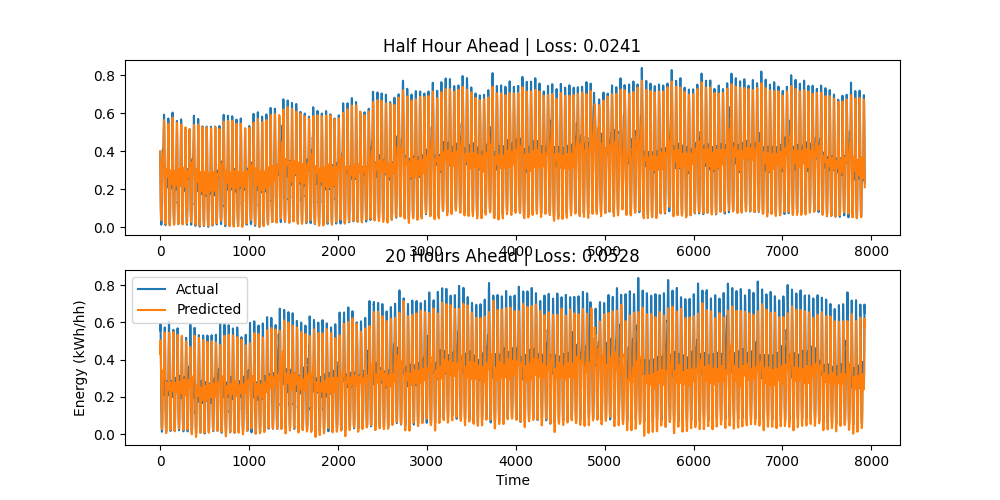

In [45]:
loss = nn.L1Loss()
x_test = dataset_test[:][0]
y_test = dataset_test[:][1]

y_pred = torch.tensor(net.predict(x_test))

half_loss = loss(y_pred[:, 0], y_test[:, 0])
hour_loss = loss(y_pred[:, 1], y_test[:, 1])
hour_half_loss = loss(y_pred[:, 2], y_test[:, 2])
hour_20_loss = loss(y_pred[:, 40], y_test[:, 40])

fig, ax = plt.subplots(2, 1, figsize=(10, 5))
ax[0].plot(y_test[:, 0], label='Actual')
ax[0].plot(y_pred[:, 0], label='Predicted')
ax[0].set_title(f'Half Hour Ahead | Loss: {half_loss:.4f}')

#ax[1].plot(y_test[:, 1], label='Actual')
#ax[1].plot(y_pred[:, 1], label='Predicted')
#ax[1].set_title(f'Hour Ahead | Loss: {hour_loss:.4f}')

#ax[2].plot(y_test[:, 2], label='Actual')
#ax[2].plot(y_pred[:, 2], label='Predicted')
#ax[2].set_title(f'Hour and Half Ahead | Loss: {hour_half_loss:.4f}')

ax[1].plot(y_test[:, 40], label='Actual')
ax[1].plot(y_pred[:, 40], label='Predicted')
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Energy (kWh/hh)')
ax[1].set_title(f'20 Hours Ahead | Loss: {hour_20_loss:.4f}')

plt.legend()
plt.show()

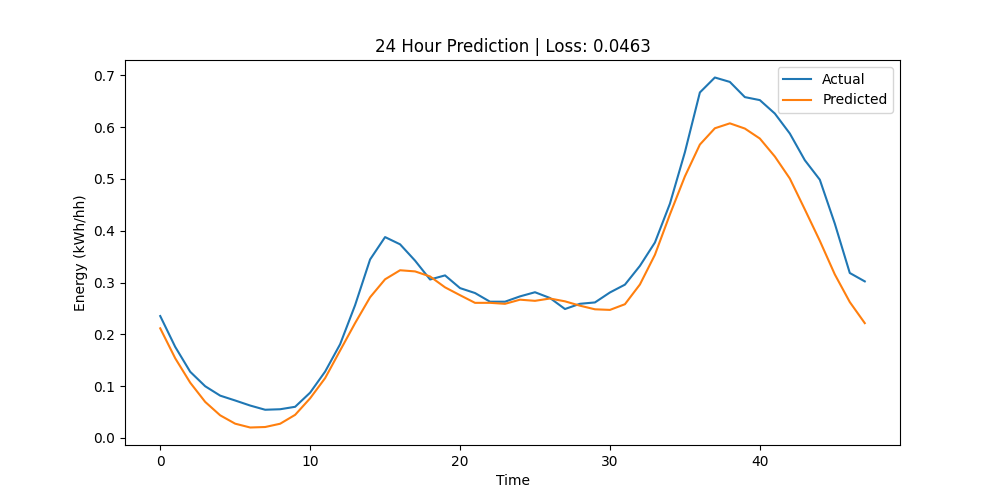

In [46]:
loss = nn.L1Loss()

overall_loss = loss(y_pred, y_test).item()

fig, ax = plt.subplots(1, 1, figsize=(10, 5))

ax.plot(y_test[-1], label='Actual')
ax.plot(y_pred[-1], label='Predicted')
ax.set_xlabel('Time')
ax.set_ylabel('Energy (kWh/hh)')
ax.set_title(f'24 Hour Prediction | Loss: {overall_loss:.4f}')
plt.legend()